In [1]:
#匯入套件與設定環境
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
import requests

844 136


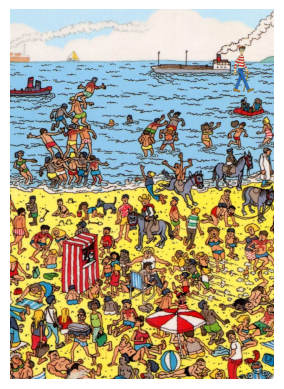

In [2]:
#讀取圖片與前處理(固定圖片尺寸，將威利合成到背景中)
BG_WIDTH = 1000
BG_HEIGHT = 1400
WALDO_WIDTH = 80
WALDO_HEIGHT = 180

def generate_sample_image():
    # 背景
    bg_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/bg07.jpg"
    bg_response = requests.get(bg_url)
    bg_array = np.frombuffer(bg_response.content, np.uint8)
    bg = cv2.imdecode(bg_array, cv2.IMREAD_COLOR)
    bg_resized = cv2.resize(bg, (BG_WIDTH, BG_HEIGHT))
    bg_rgb = cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB)

    # 威利
    waldo_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/waldo.png"
    waldo_response = requests.get(waldo_url)
    waldo_array = np.frombuffer(waldo_response.content, np.uint8)
    waldo = cv2.imdecode(waldo_array, cv2.IMREAD_UNCHANGED)
    waldo_resized = cv2.resize(waldo, (WALDO_WIDTH, WALDO_HEIGHT))
    waldo_rgb = cv2.cvtColor(waldo_resized[:, :, :3], cv2.COLOR_BGR2RGB)
    alpha_mask = waldo_resized[:, :, 3] / 255.0  # 取出Alpha通道並正規化到0-1

    # 隨機產生waldo出現的座標，避免超出bg範圍
    col_range = (0, BG_WIDTH - WALDO_WIDTH)
    row_range = (0, BG_HEIGHT - WALDO_HEIGHT)
    col = np.random.randint(*col_range)
    row = np.random.randint(*row_range)

    # alpha_mask為0，表示完全透明，背景不變
    for c in range(3):
        bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c] = (
            alpha_mask * waldo_rgb[:, :, c] +
            (1 - alpha_mask) * bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c]
        )

    return bg_rgb, (col, row)

# 測試函式
bg_rgb, (col, row) = generate_sample_image()
plt.imshow(bg_rgb)
plt.axis("off")
print(col, row)
plt.show()

844 136


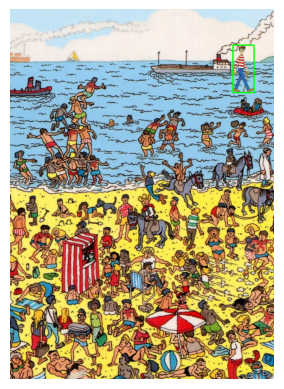

In [3]:
#繪製邊界框(正確答案為綠色外框，偵測結果為紅色外框)

def plot_bounding_box(image, ground_truth_pos, prediction_pos = None):

  cv2.rectangle(image, (ground_truth_pos[0], ground_truth_pos[1]),
             (ground_truth_pos[0] + WALDO_WIDTH, ground_truth_pos[1] + WALDO_HEIGHT),
             (0, 255, 0), 3)
  if prediction_pos is not None:
    cv2.rectangle(image, (prediction_pos[0], prediction_pos[1]),
               (prediction_pos[0] + WALDO_WIDTH, prediction_pos[1] + WALDO_HEIGHT),
               (255, 0, 0), 3)
  return image

#測試函式
image = plot_bounding_box(bg_rgb, (col, row))
plt.imshow(image)
plt.axis("off")
print(col, row)
plt.show()

In [4]:
#產生訓練圖片

def generate_data(batch_size = 16):

  while True:
    batch = np.zeros((batch_size, BG_HEIGHT, BG_WIDTH, 3))
    bounding_box = np.zeros((batch_size, 2))

    for i in range(batch_size):
      sample_image, pos = generate_sample_image()
      batch[i] = sample_image / 255 #正規化
      bounding_box[i, 0] = pos[0]
      bounding_box[i, 1] = pos[1]

    yield batch, bounding_box

#測試函式
train_data = generate_data()
batch, bounding_box = next(train_data) #產生一個批次的訓練資料(16組的圖片和二維座標)
print(batch.shape)
print(bounding_box.shape)

(16, 1400, 1000, 3)
(16, 2)


In [5]:
#定義模型架構

#卷積層
def convolutional_block(inputs):

  x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  return x

#迴歸層(全連接層)
def regression_block(x):

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  x = tf.keras.layers.Dense(2)(x)

  return x

#自行定義的函式，用於觀察訓練過程
def test_model():

  fig, ax = plt.subplots(1, 3, figsize = (15, 5))

  for i in range(3):
    #取得測試圖片
    sample_image, pos = generate_sample_image()
    sample_image_normalized = sample_image.reshape(1, BG_HEIGHT, BG_WIDTH, 3) / 255

    #使用模型偵測
    predicted_box = model.predict(sample_image_normalized)
    predicted_box = np.round(predicted_box[0]).astype(int)
    print("predicted_box:", predicted_box)

    #繪製邊界框
    img = plot_bounding_box(sample_image, pos, predicted_box)

    ax[i].imshow(img)
    ax[i].axis("off")

  plt.show()

#每2個epoch觀察一次訓練結果(ex:第1次, 第3次, 第5次)
class VisCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = None):
    if epoch % 2 == 0:
      test_model()

#每5個epoch調整一次學習率，加速收斂
def learning_rate_schedule(epoch, lr):

  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7) #學習率最低為0.0000003




#建立模型
inputs = tf.keras.Input((BG_HEIGHT, BG_WIDTH, 3))
x = convolutional_block(inputs)
box_output = regression_block(x)
model = tf.keras.Model(inputs = inputs, outputs = box_output)

#編譯模型
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = ["mse"])

In [6]:
def iou_metric(ground_truth_pos, prediction_pos):

  #取得預測框的座標
  pred_x_min, pred_y_min = prediction_pos[0], prediction_pos[1]
  pred_x_max = pred_x_min + WALDO_WIDTH
  pred_y_max = pred_y_min + WALDO_HEIGHT

  #若預測框超出影像範圍，則IoU = 0
  out_of_bounds = tf.logical_or(
      tf.logical_or(pred_x_min < 0, pred_y_min < 0),
      tf.logical_or(pred_x_max > BG_WIDTH, pred_y_max > BG_HEIGHT)
  )

  if tf.reduce_any(out_of_bounds):
      return tf.constant(0.0, dtype=tf.float32)

  #取得真實框的座標
  true_x_min, true_y_min = ground_truth_pos[0], ground_truth_pos[1]
  true_x_max = true_x_min + WALDO_WIDTH
  true_y_max = true_y_min + WALDO_HEIGHT

  #計算交集區域
  x1 = tf.maximum(true_x_min, pred_x_min)
  y1 = tf.maximum(true_y_min, pred_y_min)
  x2 = tf.minimum(true_x_max, pred_x_max)
  y2 = tf.minimum(true_y_max, pred_y_max)

  inter_width = tf.maximum(x2 - x1, 0)
  inter_height = tf.maximum(y2 - y1, 0)
  inter_area = inter_width * inter_height

  #計算面積（預設為固定大小的框）
  true_area = WALDO_WIDTH * WALDO_HEIGHT
  pred_area = WALDO_WIDTH * WALDO_HEIGHT

  #計算聯集區域
  union_area = true_area + pred_area - inter_area

  #計算IoU，避免除以0
  iou = inter_area / tf.maximum(union_area, 1e-9)

  return iou


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted_box: [ 94 166]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
predicted_box: [ 93 166]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
predicted_box: [ 93 166]


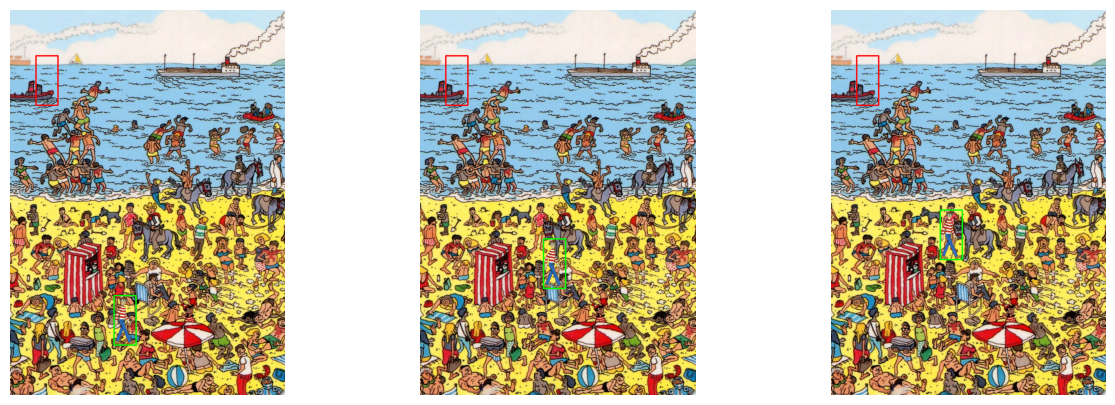

10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - loss: 442605.6875 - mse: 442605.6875 - learning_rate: 0.0010


In [7]:
#訓練模型(每個step產生16張圖片，每個epoch跑100次step，總共10個epoch)
model.fit(generate_data(), epochs = 1, steps_per_epoch = 10,
     callbacks = [VisCallback(), tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)])

In [8]:
#評估模型

model.evaluate(generate_data(), steps = 10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 283255.8750 - mse: 283255.8750


[288318.90625, 288318.90625]

In [ ]:
#儲存模型

import os
from google.colab import drive

#掛載google雲端硬碟
drive.mount("/content/drive")

#資料夾不存在則建立一個
model_dir = "/content/drive/MyDrive/WheresWaldo/saved_models"
os.makedirs(model_dir, exist_ok=True)

#儲存模型為.keras格式並壓縮上傳
model.save("/content/drive/MyDrive/WheresWaldo/saved_models/WheresWaldo_0312.keras")
!tar -czvf WheresWaldo_0312.keras.tar.gz /content/drive/MyDrive/WheresWaldo/saved_models/WheresWaldo_0312.keras

!ls /content/drive/MyDrive/WheresWaldo/saved_models/

Mounted at /content/drive


In [ ]:
#載入模型

import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/WheresWaldo/saved_models/WheresWaldo_0312.keras")

#查看模型架構
model.summary()

In [ ]:
#成果展示

In [ ]:
print('push user interface branch to github tset')